In [2]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [3]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial

In [4]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/RI/RI_probation_model_inputs.yaml')
test_sim.data_dict['transitions_data'].loc[test_sim.data_dict['transitions_data'].compartment == 'prison_technical', 'outflow_to'] = 'release'
# test_sim.simulate_baseline(['probation', 'prison_technical', 'prison_new_offense'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 108 results
transitions_data returned 12 results
total_population_data returned 96 results


In [9]:
test_sim.data_dict['transitions_data']

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,RI_probation,960.0,release,release,1.000,None,x,None,None,2021-01-14 22:58:24.563891+00:00
1,RI_probation,44.0,probation,release,0.742,None,x,None,None,2021-01-14 22:58:24.563891+00:00
2,RI_probation,12.0,probation,prison_new_offense,0.044,None,x,None,None,2021-01-14 22:58:24.563891+00:00
3,RI_probation,24.0,probation,prison_new_offense,0.042,None,x,None,None,2021-01-14 22:58:24.563891+00:00
4,RI_probation,36.0,probation,prison_new_offense,0.040,None,x,None,None,2021-01-14 22:58:24.563891+00:00
5,RI_probation,48.0,probation,prison_new_offense,0.039,None,x,None,None,2021-01-14 22:58:24.563891+00:00
6,RI_probation,12.0,probation,prison_technical,0.024,None,x,None,None,2021-01-14 22:58:24.563891+00:00
7,RI_probation,24.0,probation,prison_technical,0.023,None,x,None,None,2021-01-14 22:58:24.563891+00:00
8,RI_probation,36.0,probation,prison_technical,0.023,None,x,None,None,2021-01-14 22:58:24.563891+00:00
9,RI_probation,48.0,probation,prison_technical,0.022,None,x,None,None,2021-01-14 22:58:24.563891+00:00


In [4]:
test_sim.pop_simulations['baseline'].gen_scale_factors_df()

,x
prison_new_offense,1.101832
prison_technical,0.876628
probation,1.204529


initialization time:  12.521041870117188
simulation_time:  8.714752197265625
initialization time:  12.570426225662231
simulation_time:  8.54020094871521


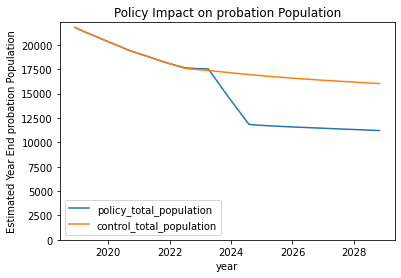

In [5]:
# Policy Option Methods

GOOD_TIME_DAYS_BACK_PER_MONTH = 17
GOOD_TIME_PARTIPICATION_RATE = 1
SIMPLE_TECHNICAL_REVOCATION_FRACTION = 0.8


def good_time_credits(retroactive=False):
    return partial(CompartmentTransitions.apply_reduction,
                   reduction_df = pd.DataFrame({'outflow': ['release'], 
                                                'reduction_size': [1 - 30/(30 + GOOD_TIME_DAYS_BACK_PER_MONTH)],
                                                'affected_fraction': [GOOD_TIME_PARTIPICATION_RATE]}),
                   reduction_type='*',
                   retroactive=retroactive)

def simple_technical_revocations(retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow,
                   reallocation_df=pd.DataFrame({'outflow': ['prison_technical'], 
                                                 'affected_fraction': [SIMPLE_TECHNICAL_REVOCATION_FRACTION], 
                                                 'new_outflow': ['release']}),
                   reallocation_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [SparkPolicy(policy_fn=simple_technical_revocations(False),
                                           spark_compartment='probation',
                                           sub_population={'crime_type': 'x'},
                                           apply_retroactive=False),
                               SparkPolicy(policy_fn=good_time_credits(False),
                                           spark_compartment='probation',
                                           sub_population={'crime_type': 'x'},
                                           apply_retroactive=False),
                              ]



    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'probation')

In [6]:
simulation_tag = 'RI_probation%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)